<a href="https://colab.research.google.com/github/richayanamandra/GenAI-Experiments/blob/main/genAI_lab3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = datasets.FashionMNIST(
    root="./data", train=True, transform=transform, download=True
)

test_data = datasets.FashionMNIST(
    root="./data", train=False, transform=transform, download=True
)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)


100%|██████████| 26.4M/26.4M [00:00<00:00, 115MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.83MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 57.5MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 27.6MB/s]


In [3]:
#VAE Architecture
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        self.mu = nn.Linear(256, latent_dim)
        self.logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar


In [4]:
#Loss Function
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [5]:
#Hyperparameter Tuning
def train_model(latent_dim, lr, epochs=8):
    model = VAE(latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    total_loss = 0

    for epoch in range(epochs):
        for x, _ in train_loader:
            x = x.view(-1, 784).to(device)

            recon, mu, logvar = model(x)
            loss = vae_loss(recon, x, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    return total_loss / len(train_loader.dataset)


In [6]:
search_space = {
    "latent": [2, 8, 16],
    "lr": [1e-3, 5e-4]
}

best_loss = float("inf")
best_params = None

for z in search_space["latent"]:
    for lr in search_space["lr"]:
        print(f"Testing latent={z}, lr={lr}")
        loss = train_model(z, lr)
        print("Loss:", round(loss, 2))

        if loss < best_loss:
            best_loss = loss
            best_params = (z, lr)

print("\nBest Params:", best_params)


Testing latent=2, lr=0.001
Loss: 2124.57
Testing latent=2, lr=0.0005
Loss: 2141.08
Testing latent=8, lr=0.001
Loss: 1993.08
Testing latent=8, lr=0.0005
Loss: 2022.41
Testing latent=16, lr=0.001
Loss: 2000.36
Testing latent=16, lr=0.0005
Loss: 2029.87

Best Params: (8, 0.001)


In [7]:
#Train Best model
latent_dim, lr = best_params
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []

EPOCHS = 30

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for x, _ in train_loader:
        x = x.view(-1, 784).to(device)

        recon, mu, logvar = model(x)
        loss = vae_loss(recon, x, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.2f}")


Epoch 1/30 | Loss: 283.20
Epoch 2/30 | Loss: 252.42
Epoch 3/30 | Loss: 247.74
Epoch 4/30 | Loss: 244.81
Epoch 5/30 | Loss: 243.14
Epoch 6/30 | Loss: 242.09
Epoch 7/30 | Loss: 241.41
Epoch 8/30 | Loss: 240.81
Epoch 9/30 | Loss: 240.30
Epoch 10/30 | Loss: 240.00
Epoch 11/30 | Loss: 239.57
Epoch 12/30 | Loss: 239.25
Epoch 13/30 | Loss: 239.05
Epoch 14/30 | Loss: 238.78
Epoch 15/30 | Loss: 238.57
Epoch 16/30 | Loss: 238.40
Epoch 17/30 | Loss: 238.26
Epoch 18/30 | Loss: 238.11
Epoch 19/30 | Loss: 237.97
Epoch 20/30 | Loss: 237.77
Epoch 21/30 | Loss: 237.63
Epoch 22/30 | Loss: 237.55
Epoch 23/30 | Loss: 237.47
Epoch 24/30 | Loss: 237.37
Epoch 25/30 | Loss: 237.23
Epoch 26/30 | Loss: 237.14
Epoch 27/30 | Loss: 237.08
Epoch 28/30 | Loss: 237.00
Epoch 29/30 | Loss: 236.98
Epoch 30/30 | Loss: 236.81


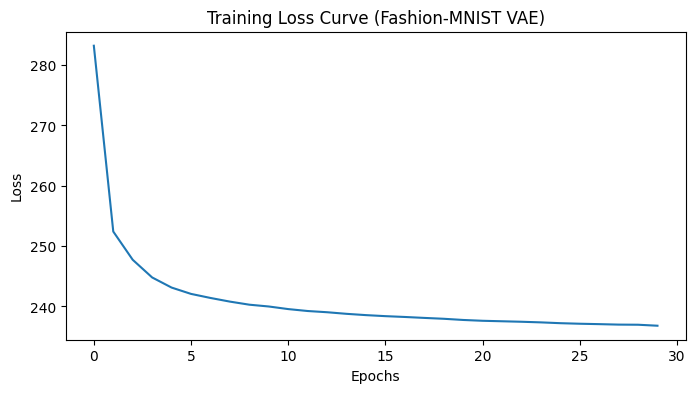

In [8]:
#Loss Curve
plt.figure(figsize=(8,4))
plt.plot(train_losses)
plt.title("Training Loss Curve (Fashion-MNIST VAE)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


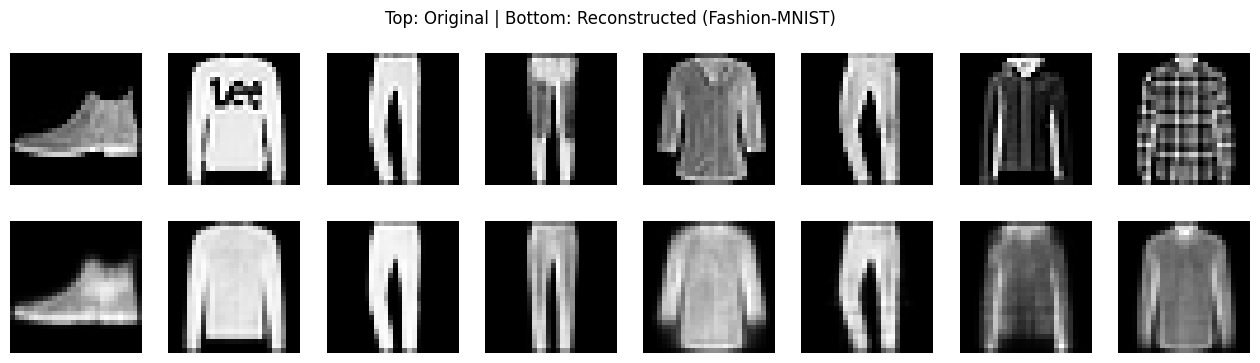

In [9]:
#Reconstruction Visualization
model.eval()
x, _ = next(iter(test_loader))
x = x.view(-1, 784).to(device)

with torch.no_grad():
    recon, _, _ = model(x)

n = 8
plt.figure(figsize=(16,4))

for i in range(n):
    # Original
    plt.subplot(2, n, i+1)
    plt.imshow(x[i].cpu().view(28,28), cmap="gray")
    plt.axis("off")

    # Reconstructed
    plt.subplot(2, n, i+n+1)
    plt.imshow(recon[i].cpu().view(28,28), cmap="gray")
    plt.axis("off")

plt.suptitle("Top: Original | Bottom: Reconstructed (Fashion-MNIST)")
plt.show()


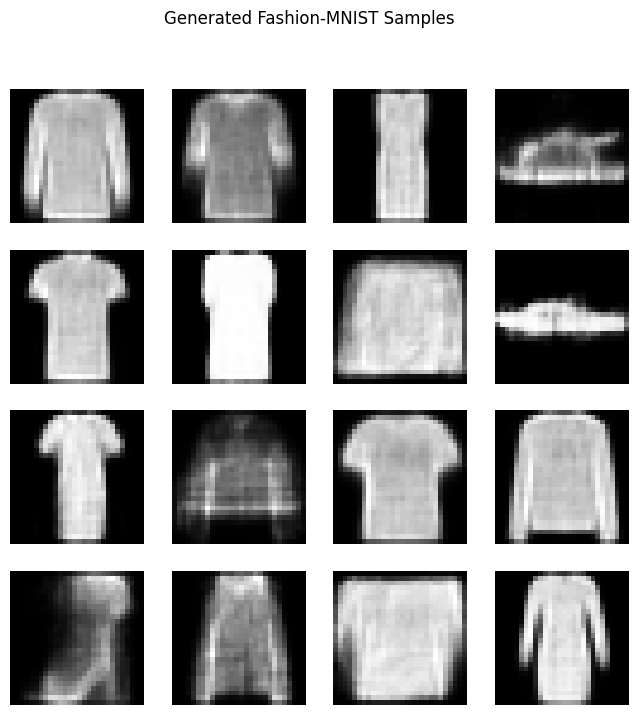

In [10]:
#Generate new samples
z = torch.randn(16, latent_dim).to(device)

with torch.no_grad():
    samples = model.decoder(z).cpu()

plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(samples[i].view(28,28), cmap="gray")
    plt.axis("off")

plt.suptitle("Generated Fashion-MNIST Samples")
plt.show()
